## Robson de Oliveira Caldas - 1831134018

## 1 - Banco de dados

### Conjunto de LOGs de um servidor Web Apache2.

O objetivo é classificar os acessos como reais (feitos por humanos) e fake (feitos por bots), a fim de bloquear os fakes e reduzir o tráfego desnecessário no servidor.

Bots, spiders e outros rastreadores que acessam as páginas dinâmicas podem causar uso extensivo de recursos (memória e CPU). Isso pode levar a uma alta carga no servidor e atrasar o site legítimo. Existem ainda os bots maliciosos, que vasculham o servidor em busca de vulnerabilidades constantemente.


#### Multiplos arquivos de log

Os logs são armazenados no servidor em arquivos separados, aqui vamos juntar todos em um só arquivo para o processamento:

In [1]:
# import lib.merge_logs as merge
# merge.merge('log/access.log')

## 2 - Pré-processamento

### Logs no arquivo 'access.log.all'. Criar um DataFrame Pandas:

In [2]:
"""
RCaldas Log Parser.
"""
import sys,os
import time
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import Counter
%matplotlib inline

try:
    log = open('log/access.log.all')
except IOError:
    print(__doc__,"\nErro ao ler o arquivo de log.")
    sys.exit(1)

### Dataframe
df = []
### Acumulador de palavras do campo Agent
tags_total = []
### Acumulador de IPs de bot
ipsbot = []
### Acumulador de IPs de humanos
ipshum = []
### Regex para pegar os campos corretos de cada linha
regc = re.compile('^(?P<ip>\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) .+'
                  ' \[(?P<time>[0-9]+/\S+:\d{2}:\d{2}:\d{2} .+)\] '
                  '\"(?P<met>\S+) (?P<urn>\S+) \S+\" (?P<code>\d+) '
                  '(?P<size>\d+) \"(?P<identd>[^\"]+)\" \"(?P<agent>[^\"]*)\"')

### Loop em cada linha do arquivo:
for line in log:
    try:
        ### Armazenar os dados capturados com o regex (IP, URN, Código HTTP, Tamanho):
        m = regc.match(line)
        ip, urn, code, size = m.group('ip', 'urn', 'code', 'size')
        
        ### Converter data e hora para formato datetime
        datahora = datetime.datetime.strptime(m.group('time'), '%d/%b/%Y:%H:%M:%S %z')
        
        ### Método já categorizado = GET: 0, POST: 1, OUTRO: 2
        if m.group('met') == 'GET': metodo = 0
        elif m.group('met') == 'POST': metodo = 1
        else: metodo = 2
        
        ### Tem algo no identd?
        if m.group('identd') == '-': identd = 0
        else: identd = 1
        
        ### Informaçoes do agente acumulando em 'tags_total'
        agent = m.group('agent')
        tags = []
        for i in agent.split():
            i = i.split('/')[0]
            i = i.strip(';/)(.,')
            tags.append(i)
            tags_total.append(i)

    except:
        ### print('Linha fora do padrão:\n', line)
        continue
        
    ### Alimentar o dataframe com os dados:
    df.append({'IP': ip, 'Data': datahora, 'Metodo': metodo, 'Request': urn, 
               'Code': code, 'Bytes': size, 'Identd': identd, 'Agent': agent})
log.close()
df = pd.DataFrame(df)

### Converter as colunas numéricas em inteiro:
df['Bytes'] = pd.to_numeric(df['Bytes'])
df['Code'] = pd.to_numeric(df['Code'])

### Preencher as colunas Bot e Humano
df['Bot'] = 0
df['Hum'] = 0

### Randomizar as posiçoes dos dados:
df = df.sample(frac=1).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17578 entries, 0 to 17577
Data columns (total 10 columns):
Agent      17578 non-null object
Bytes      17578 non-null int64
Code       17578 non-null int64
Data       17578 non-null datetime64[ns, UTC-03:00]
IP         17578 non-null object
Identd     17578 non-null int64
Metodo     17578 non-null int64
Request    17578 non-null object
Bot        17578 non-null int64
Hum        17578 non-null int64
dtypes: datetime64[ns, UTC-03:00](1), int64(6), object(3)
memory usage: 1.3+ MB


**Descrição das variáveis:**

- Agent   : informações do agente (browser) como versão, compatibilidades, sistema operacional...
- Bytes   : Tamanho em bytes da requisição
- Code    : Código HTTP recebido (200: OK, 404: Not Found, 301: Redirect ...)
- Data    : Data e hora do acesso
- IP      : IP do cliente
- Identd  : Campo de identificação, presente geralmente em acessos já iniciados, não no primeiro GET.
- Metodo  : Metodo da requisição (GET: 0, POST:1, OUTROS:2)
- Request : URN solicitado para o servidor (Ex: /wp-admin.php)

In [3]:
df.head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6...,887,200,2019-03-25 12:58:03-03:00,167.249.249.102,1,0,/wp-content/plugins/Ultimate_VC_Addons/assets/...,0,0
1,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,41593,200,2019-03-15 11:01:31-03:00,179.153.187.200,1,0,/wp-content/uploads/LogoTVBsb.png,0,0
2,Mozilla/5.0 (Windows NT 6.1; rv:52.0) Gecko/20...,64211,404,2019-03-14 01:04:21-03:00,189.59.5.91,0,0,/?author=46,0,0
3,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:45.64....,5343,200,2019-03-22 18:41:53-03:00,123.21.91.167,1,1,/wp-login.php,0,0
4,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,566,301,2019-03-26 01:16:35-03:00,158.69.243.5,0,0,/sql.tar.gz,0,0


## 3 - Análise da Distribuição

### * Bytes e Request

#### Os bytes são maiores quando o campo Identd existe.
#### Requests grandes sem identd tem mais chances de ser bot.

In [4]:
### Cria uma coluna com o tamanho do Request para comparar com os Bytes
req_Len = []
for i in df.Request.apply(len):
    req_Len.append(i)
df['rLen'] = req_Len

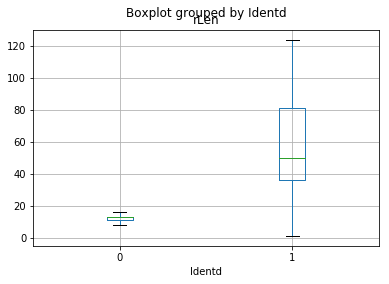

In [5]:
### Tamanho do Request por Identd, excluindo os outliers
df.boxplot(column='rLen', by = 'Identd', showfliers=False)

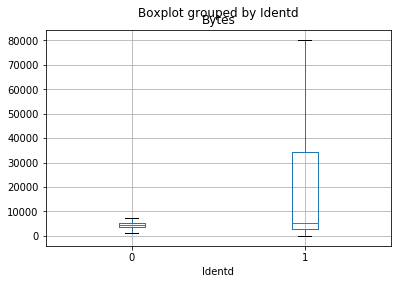

In [6]:
## Tamanho da requisição por Identd, excluindo os outliers
df.boxplot(column='Bytes', by = 'Identd', showfliers=False)

In [7]:
### Exibir os valores para comparar
df[['rLen','Bytes']].tail(10)

,rLen,Bytes
17568,40,35332
17569,1,3620
17570,1,583
17571,13,4753
17572,1,3570
17573,13,607
17574,58,225670
17575,71,15426
17576,13,4753
17577,60,3304


In [8]:
### Ver percentil dos requests
df['rLen'].describe()

count    17578.000000
mean        42.545853
std         36.540780
min          1.000000
25%         13.000000
50%         36.000000
75%         65.000000
max        534.000000
Name: rLen, dtype: float64

In [9]:
## Analisar os registros com Request maiores que 63 (75%) que não tenham Identd
df[(df['rLen']>=63) & (df['Identd']==0)].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
8,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,20669,200,2019-03-16 19:05:46-03:00,207.46.13.136,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,99
99,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,3722,400,2019-03-20 04:18:23-03:00,192.99.35.149,0,0,/wp-admin/admin-ajax.php?action=revslider_show...,0,0,73
182,Mozilla/4.0 (compatible; MSIE 9.0; Windows NT ...,1063,301,2019-04-03 09:55:26-03:00,118.24.58.56,0,0,/index.php?s=%2f%69%6e%64%65%78%2f%5c%74%68%69...,0,0,252
207,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.1...,6744,200,2019-03-13 21:08:40-03:00,34.209.184.179,0,0,/wp-content/plugins/Ultimate_VC_Addons/assets/...,0,0,71
219,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Ma...,20034,200,2019-03-17 04:36:00-03:00,40.77.189.226,0,0,/wp-content/plugins/Ultimate_VC_Addons/assets/...,0,0,66
270,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:50.0) G...,6256,200,2019-03-21 21:02:51-03:00,54.186.48.55,0,0,/wp-content/plugins/js_composer/assets/js/dist...,0,0,81
286,-,744,301,2019-03-16 00:51:21-03:00,110.83.60.28,0,0,/wp-content/plugins/wp-jobhunt/templates/eleme...,0,0,94
295,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,38891,200,2019-03-16 19:05:46-03:00,207.46.13.136,0,0,/wp-content/plugins/revslider/public/assets/js...,0,0,87
303,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,5517,200,2019-04-08 14:36:25-03:00,207.46.13.187,0,0,/wp-content/plugins/Ultimate_VC_Addons/assets/...,0,0,71
331,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Ma...,23373,200,2019-03-19 05:18:39-03:00,40.77.188.182,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,109


In [10]:
### Ver percentil dos Bytes
df['Bytes'].describe()

count    1.757800e+04
mean     1.783226e+04
std      4.662834e+04
min      0.000000e+00
25%      3.053000e+03
50%      4.752000e+03
75%      1.308900e+04
max      2.037909e+06
Name: Bytes, dtype: float64

In [11]:
### Analisar os registros com Request maiores que percentil de 75% que não tenham Identd
df[(df['Bytes']>=12645) & (df['Identd']==0)].head(10)

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
2,Mozilla/5.0 (Windows NT 6.1; rv:52.0) Gecko/20...,64211,404,2019-03-14 01:04:21-03:00,189.59.5.91,0,0,/?author=46,0,0,11
8,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,20669,200,2019-03-16 19:05:46-03:00,207.46.13.136,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,99
55,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Ma...,61063,200,2019-03-17 04:35:53-03:00,40.77.188.31,0,0,/wp-content/uploads/br06-200x200.jpg,0,0,36
56,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Ma...,20284,200,2019-03-17 04:36:02-03:00,40.77.190.140,0,0,/wp-content/uploads/LLbg333.jpg,0,0,31
63,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,30621,200,2019-03-22 13:43:25-03:00,23.100.232.233,0,0,/,0,0,1
69,Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Ma...,70800,200,2019-03-17 04:35:52-03:00,40.77.188.3,0,0,/wp-content/uploads/crk05-200x200.jpg,0,0,37
125,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:65....,31134,200,2019-03-20 21:31:28-03:00,166.78.150.25,0,0,/,0,0,1
147,Mozilla/5.0 (Windows NT 6.1; rv:52.0) Gecko/20...,64211,404,2019-03-18 01:06:30-03:00,59.21.169.153,0,0,/?author=43,0,0,11
174,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,30621,200,2019-03-22 17:05:51-03:00,23.100.232.233,0,0,/,0,0,1
179,Mozilla/5.0 (compatible; Dataprovider.com),110745,200,2019-03-16 10:28:37-03:00,158.69.27.211,0,0,/wp-content/uploads/br05.jpg?gid=1,0,0,34


#### Marcar IPs com agents estranhos como o seguinte:

In [12]:
df.iloc[16070]

Agent      Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
Bytes                                                    634
Code                                                     301
Data                               2019-03-19 23:49:22-03:00
IP                                             5.135.143.224
Identd                                                     1
Metodo                                                     0
Request        /wp-content/plugins/easy-wp-smtp/js/script.js
Bot                                                        0
Hum                                                        0
rLen                                                      45
Name: 16070, dtype: object

In [13]:
### Ver os registros desse IP
df[df['IP']=="94.23.255.34"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
93,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,3926,404,2019-04-03 08:13:05-03:00,94.23.255.34,1,0,/webconfig.txt.php,0,0,18
643,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,3932,404,2019-04-03 08:14:05-03:00,94.23.255.34,1,1,//wp-admin/admin-post.php?swp_debug=load_optio...,0,0,150
1046,Python-urllib/2.7,4179,200,2019-04-03 08:12:19-03:00,94.23.255.34,0,0,/?1=%40ini_set%28%22display_errors%22%2C%220%2...,0,0,311
1121,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,608,301,2019-04-03 08:13:03-03:00,94.23.255.34,1,0,///webconfig.txt.php,0,0,20
1300,Python-urllib/2.7,4179,200,2019-04-03 03:57:44-03:00,94.23.255.34,0,0,/?1=%40ini_set%28%22display_errors%22%2C%220%2...,0,0,311


In [14]:
### Guardar esse IP como bot
ipsbot.append('94.23.255.34')

In [15]:
### Bot com bytes altos e rLen pequeno
ipsbot.append('93.119.227.34')
df[df['IP']=="93.119.227.34"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
2138,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; ...,3383,421,2019-03-27 04:32:30-03:00,93.119.227.34,0,0,/,0,0,1
4233,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,3537,301,2019-03-27 04:32:31-03:00,93.119.227.34,0,0,/,0,0,1
6181,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,202148,200,2019-03-27 04:32:32-03:00,93.119.227.34,0,0,/,0,0,1
14291,Wget/1.13.4 (linux-gnu),202148,200,2019-03-27 04:32:31-03:00,93.119.227.34,0,0,/,0,0,1
16907,Mozilla/5.0 (Linux; Android 7.0; SM-G930V Buil...,3383,421,2019-03-27 04:32:30-03:00,93.119.227.34,0,0,/,0,0,1


In [16]:
### Bot
ipsbot.append('54.149.94.16')
df[df['IP']=="54.149.94.16"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
377,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,3980,200,2019-04-02 23:09:06-03:00,54.149.94.16,1,0,/,0,0,1
2647,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:55.0) ...,3820,404,2019-04-02 23:09:05-03:00,54.149.94.16,1,0,/robots.txt,0,0,11
3148,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:55.0) ...,582,301,2019-04-02 23:09:04-03:00,54.149.94.16,1,0,/robots.txt,0,0,11
7717,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:55.0) ...,3824,404,2019-04-02 23:09:05-03:00,54.149.94.16,1,0,/robots.txt,0,0,11
9354,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,574,301,2019-04-02 23:09:05-03:00,54.149.94.16,1,0,/,0,0,1


In [17]:
### Bot
ipsbot.append('13.53.136.118')
df[df['IP']=="13.53.136.118"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
4461,CheckMarkNetwork/1.0 (+http://www.checkmarknet...,581,404,2019-04-03 00:00:44-03:00,13.53.136.118,0,0,/robots.txt,0,0,11
5428,CheckMarkNetwork/1.0 (+http://www.checkmarknet...,3984,200,2019-04-03 00:00:45-03:00,13.53.136.118,0,0,/,0,0,1
7923,CheckMarkNetwork/1.0 (+http://www.checkmarknet...,3632,200,2019-04-03 00:00:44-03:00,13.53.136.118,0,2,/,0,0,1
12850,CheckMarkNetwork/1.0 (+http://www.checkmarknet...,236,301,2019-04-03 00:00:44-03:00,13.53.136.118,0,2,/,0,0,1


In [18]:
### Bot
ipsbot.append('103.129.220.250')
ipsbot.append('138.197.68.2')
ipsbot.append('104.131.6.66')
df[df['IP']=="104.131.6.66"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
1721,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-19 22:27:13-03:00,104.131.6.66,0,0,/wp-login.php,0,0,13
4235,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,4753,200,2019-03-19 22:27:18-03:00,104.131.6.66,0,0,/wp-login.php,0,0,13
5832,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,3566,200,2019-03-19 22:27:19-03:00,104.131.6.66,0,1,/xmlrpc.php,0,0,11
6108,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,5145,200,2019-03-19 22:27:18-03:00,104.131.6.66,0,1,/wp-login.php,0,0,13
11623,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,3566,200,2019-03-19 23:36:48-03:00,104.131.6.66,0,1,/xmlrpc.php,0,0,11


### * Code
####  Muitos GETs retornando 404 significa algum bot fazendo varredura por bruteforce.

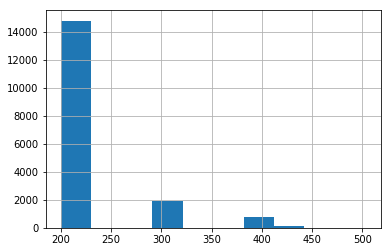

In [19]:
df['Code'].hist()

In [20]:
df['Code'].value_counts()

200    14797
301     1931
404      593
400      145
421       93
302        6
500        4
206        3
503        2
405        2
304        2
Name: Code, dtype: int64

### * Agent
#### Analisar os Agents mais comuns

In [21]:
### Gerar a lista dos nomes mais usadas no campo 'Agent':
tagsorted = sorted([(value, key) for (key,value) in Counter(tags_total).items()], reverse=True)

topagents = [x[1] for x in tagsorted[:11]]
for top in topagents: print(top)

Mozilla
Gecko
Windows
NT
like
KHTML
AppleWebKit
Safari
Linux
Firefox
Chrome


In [22]:
## Analisar os logs pelo campo 'Agent'
df.loc[(df['Agent'].str.contains('Mozilla')==False) & 
       (df['Agent'].str.contains('http')==False)  & 
       (df['Agent'].str.contains('Wget')==False),
       ['Agent','Request','IP']].head()

,Agent,Request,IP
107,Microsoft URL Control - 6.00.8862,/,35.190.190.244
124,Microsoft URL Control - 6.00.8862,/,35.190.190.244
286,-,/wp-content/plugins/wp-jobhunt/templates/eleme...,110.83.60.28
348,Microsoft URL Control - 6.00.8862,/,35.233.154.198
403,-,/shop/,80.84.57.114


In [23]:
### Bot
ipsbot.append('91.230.25.106')
df[df['IP']=="91.230.25.106"].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
3822,Mozilla/5.0 (X11; Linux x86_64; rv:3.4) Goanna...,583,301,2019-03-18 15:50:43-03:00,91.230.25.106,1,0,/,0,0,1
9442,Mozilla/5.0 (X11; Linux x86_64; rv:3.4) Goanna...,31133,200,2019-03-18 15:50:44-03:00,91.230.25.106,0,0,/,0,0,1
10158,Opera/9.80 (Windows NT 6.2; Win64; x64) Presto...,1756,200,2019-03-18 15:50:46-03:00,91.230.25.106,1,0,/wp-login.php?registration=disabled,0,0,35
11825,Opera/9.80 (Windows NT 6.2; Win64; x64) Presto...,496,302,2019-03-18 15:50:46-03:00,91.230.25.106,1,0,/wp-login.php?action=register,0,0,29


In [24]:
### Bot
ipsbot.append('80.84.57.96')
ipsbot.append('80.84.57.101')
ipsbot.append('80.84.57.93')
df[df['IP'].str.contains("80.84.57")].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
403,-,3586,404,2019-03-17 07:06:34-03:00,80.84.57.114,0,0,/shop/,0,0,6
2506,-,201946,200,2019-03-17 07:05:44-03:00,80.84.57.94,0,0,/,0,0,1
3316,-,201946,200,2019-03-17 07:05:37-03:00,80.84.57.101,0,0,/,0,0,1
3889,-,3583,404,2019-03-17 07:07:44-03:00,80.84.57.96,0,0,/store/,0,0,7
6022,-,551,301,2019-03-17 07:08:13-03:00,80.84.57.97,0,0,/store/,0,0,7


In [25]:
### Bot
ipsbot.append('54.36.148.198')
ipsbot.append('54.36.148.34')
ipsbot.append('54.36.148.33')
df.loc[df['IP'].str.contains('54.36.148')].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
75,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3703,404,2019-04-02 20:43:47-03:00,54.36.148.148,0,0,/manual/ja/mod/mod_session.html,0,0,31
150,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3702,404,2019-04-02 14:30:24-03:00,54.36.148.251,0,0,/manual/fr/howto/htaccess.html,0,0,30
371,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,576,301,2019-04-02 15:46:49-03:00,54.36.148.247,0,0,/manual/pt-br/mod/mod_authn_dbd.html,0,0,36
397,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,570,301,2019-04-02 13:08:21-03:00,54.36.148.50,0,0,/manual/en/vhosts/name-based.html,0,0,33
555,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,526,301,2019-04-03 07:14:09-03:00,54.36.148.175,0,0,/robots.txt,0,0,11


In [26]:
# Agents reais: LG-H870, SM-G570M, SM-J500M, SM-J530G, j5lte
ipshum.extend(['191.39.11.138','179.153.187.200','189.40.76.184','200.130.16.5','45.56.114.108'])
df.loc[df['Agent'].str.contains('SM-J500M')].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
1,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,41593,200,2019-03-15 11:01:31-03:00,179.153.187.200,1,0,/wp-content/uploads/LogoTVBsb.png,0,0,33
178,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,48859,200,2019-03-15 11:01:32-03:00,179.153.187.200,1,0,/wp-content/uploads/fIMG_7367-200x200.jpg,0,0,41
192,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,225670,200,2019-03-15 11:01:29-03:00,179.153.187.200,1,0,/wp-content/themes/jupiter/js/scripts-vendors....,0,0,58
267,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,31146,200,2019-03-15 11:01:26-03:00,179.153.187.200,1,0,/,0,0,1
396,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,2045,200,2019-03-15 11:01:29-03:00,179.153.187.200,1,0,/wp-content/plugins/Ultimate_VC_Addons/assets/...,0,0,79


### * IP


In [27]:
## Descobrir os IPs que mais aparecem 
df['IP'].value_counts().head()

23.100.232.233     1098
45.56.114.108       494
118.24.58.56        441
189.61.19.38        314
185.211.245.199     275
Name: IP, dtype: int64

In [28]:
## Ver os registros do IP que mais aparece
df[df['IP']==df['IP'].value_counts().head().keys()[0]].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
7,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,5663,200,2019-03-20 18:14:04-03:00,23.100.232.233,1,0,/wp-includes/js/jquery/ui/effect.min.js?ver=1....,0,0,50
28,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,5738,200,2019-03-22 11:54:12-03:00,23.100.232.233,1,0,/wp-admin/admin-ajax.php?action=ContactFormmak...,0,0,74
33,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,69054,200,2019-03-20 13:30:52-03:00,23.100.232.233,1,0,/wp-content/uploads/natal-200x200.jpg,0,0,37
37,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,9754,200,2019-03-20 18:13:52-03:00,23.100.232.233,1,0,/wp-content/uploads/Ludi-lago-tt-pq.png,0,0,39
45,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,41172,200,2019-03-22 19:12:44-03:00,23.100.232.233,1,0,/wp-content/uploads/bIMG_6926-200x200.jpg,0,0,41


In [29]:
### IPs de Bots declarados e conhecidos (contém bot no campo Agent):
for i in ['118.24.58.56', '94.23.255.34', '40.77.167.172',
          '54.36.150.56', '13.53.136.118', '54.36.149.67',
          '157.55.39.139', '66.249.64.56', '54.36.150.60']:
    ipsbot.append(i)

df.loc[df['Agent'].str.contains('bot')]  

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
6,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,3615,200,2019-03-13 10:28:17-03:00,87.250.224.59,0,0,/robots.txt,0,0,11
8,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,20669,200,2019-03-16 19:05:46-03:00,207.46.13.136,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,99
18,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,570,301,2019-04-02 16:01:28-03:00,54.36.149.45,0,0,/manual/zh-cn/mod/mod_buffer.html,0,0,33
32,Google-Adwords-Instant (+http://www.google.com...,595,301,2019-03-22 14:21:44-03:00,66.102.6.245,0,0,/,0,0,1
74,Mozilla/5.0 (Windows NT 10.0; Win64; x64; BDCb...,550,200,2019-03-15 06:18:54-03:00,129.213.76.116,0,2,/wp-includes/js/comment-reply.min.js?ver=4.9.6,0,0,46
75,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3703,404,2019-04-02 20:43:47-03:00,54.36.148.148,0,0,/manual/ja/mod/mod_session.html,0,0,31
76,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1232,200,2019-03-22 16:28:00-03:00,207.46.13.63,0,0,/wp-content/themes/jupiter/js/head-scripts.js?...,0,0,55
103,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,3610,200,2019-03-26 02:00:24-03:00,66.249.64.59,0,0,/robots.txt,0,0,11
150,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,3702,404,2019-04-02 14:30:24-03:00,54.36.148.251,0,0,/manual/fr/howto/htaccess.html,0,0,30
175,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,615,301,2019-03-20 21:26:58-03:00,157.55.39.31,0,0,/robots.txt,0,0,11


### 4 - Marcações

In [30]:
### Marcar os bots reconhecidos
for ip in np.unique(ipsbot):
    df.loc[df.IP == ip, 'Bot'] = 1
df[df['Bot']==1].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
17,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:59...,579,301,2019-04-03 09:55:37-03:00,118.24.58.56,0,1,/xw.php,1,0,7
38,Mozilla/4.0 (compatible; MSIE 9.0; Windows NT ...,583,301,2019-04-03 09:55:06-03:00,118.24.58.56,0,0,/test.php,1,0,9
61,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:59...,578,301,2019-04-03 09:57:43-03:00,118.24.58.56,0,1,/ww.php,1,0,7
93,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,3926,404,2019-04-03 08:13:05-03:00,94.23.255.34,1,0,/webconfig.txt.php,1,0,18
95,Mozilla/4.0 (compatible; MSIE 9.0; Windows NT ...,581,301,2019-04-03 09:55:14-03:00,118.24.58.56,0,0,/wpo.php,1,0,8


In [31]:
### Marcar acessos humanos
for ip in np.unique(ipshum):
    df.loc[df.IP == ip, 'Hum'] = 1
df[df['Hum']==1].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen
1,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,41593,200,2019-03-15 11:01:31-03:00,179.153.187.200,1,0,/wp-content/uploads/LogoTVBsb.png,0,1,33
121,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-25 07:59:15-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553511554.73253798...,0,1,60
161,Mozilla/5.0 (Linux; Android 8.0.0; SM-G570M) A...,5663,200,2019-03-26 16:41:45-03:00,191.39.11.138,1,0,/wp-includes/js/jquery/ui/effect.min.js?ver=1....,0,1,50
178,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,48859,200,2019-03-15 11:01:32-03:00,179.153.187.200,1,0,/wp-content/uploads/fIMG_7367-200x200.jpg,0,1,41
183,Mozilla/5.0 (Linux; Android 8.0.0; SM-G570M) A...,20284,200,2019-03-26 16:41:48-03:00,191.39.11.138,1,0,/wp-content/uploads/LLbg333.jpg,0,1,31


In [32]:
### Agents que contem 'Mozilla'
df['aMoz'] = (df['Agent'].str.contains('Mozilla')).astype(int)
df[df['aMoz']==1].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen,aMoz
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6...,887,200,2019-03-25 12:58:03-03:00,167.249.249.102,1,0,/wp-content/plugins/Ultimate_VC_Addons/assets/...,0,0,80,1
1,Mozilla/5.0 (Linux; Android 6.0.1; SM-J500M Bu...,41593,200,2019-03-15 11:01:31-03:00,179.153.187.200,1,0,/wp-content/uploads/LogoTVBsb.png,0,1,33,1
2,Mozilla/5.0 (Windows NT 6.1; rv:52.0) Gecko/20...,64211,404,2019-03-14 01:04:21-03:00,189.59.5.91,0,0,/?author=46,0,0,11,1
3,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:45.64....,5343,200,2019-03-22 18:41:53-03:00,123.21.91.167,1,1,/wp-login.php,0,0,13,1
4,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:62....,566,301,2019-03-26 01:16:35-03:00,158.69.243.5,0,0,/sql.tar.gz,0,0,11,1


In [33]:
### Agentes que contem 'http:'
df['aHttp'] = (df['Agent'].str.contains('https?:')).astype(int)
df[df['aHttp']==1].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen,aMoz,aHttp
6,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,3615,200,2019-03-13 10:28:17-03:00,87.250.224.59,0,0,/robots.txt,0,0,11,1,1
8,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,20669,200,2019-03-16 19:05:46-03:00,207.46.13.136,0,0,/wp-content/plugins/gallery-by-supsystic/src/G...,0,0,99,1,1
18,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,570,301,2019-04-02 16:01:28-03:00,54.36.149.45,0,0,/manual/zh-cn/mod/mod_buffer.html,0,0,33,1,1
29,CheckMarkNetwork/1.0 (+http://www.checkmarknet...,243,301,2019-03-21 09:24:45-03:00,35.183.43.121,0,2,/,0,0,1,0,1
32,Google-Adwords-Instant (+http://www.google.com...,595,301,2019-03-22 14:21:44-03:00,66.102.6.245,0,0,/,0,0,1,0,1


In [34]:
### Agentes que contem 'WordPress'
df['aWP'] = (df['Agent'].str.contains('WordPress')).astype(int)
df[df['aWP']==1].head()

,Agent,Bytes,Code,Data,IP,Identd,Metodo,Request,Bot,Hum,rLen,aMoz,aHttp,aWP
121,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-25 07:59:15-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553511554.73253798...,0,1,60,0,1,1
283,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-22 06:14:23-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553246063.72157096...,0,1,60,0,1,1
292,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-25 19:53:39-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553554418.94707989...,0,1,60,0,1,1
333,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-18 09:07:37-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1552910856.96283292...,0,1,60,0,1,1
341,WordPress/4.9.6; https://llproducoes.com.br,3304,200,2019-03-22 22:00:59-03:00,45.56.114.108,1,1,/wp-cron.php?doing_wp_cron=1553302858.88348388...,0,1,60,0,1,1


In [35]:
### Separar os dados rotulados:
df_treino = df[(df['Hum']==1) | (df['Bot']==1)].reset_index()
df_resto = df[(df['Hum']==0) & (df['Bot']==0)].reset_index()

## 5 - Classificação

Analisar com Random Forest e testar com MLP, SVM e CNN.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import metrics

def classifica(model, data, X, Y):
    start = time.time()
    model.fit(data[X],data[Y])
    print("Tempo de treinamento: ",time.time()-start)
    predict = model.predict(data[X])
    acuracia = metrics.accuracy_score(predict, data[Y])
    print("Acuracia: %s" % "{0:.3%}".format(acuracia))

    ### Faz validação cruzada com k-fold
    kf = KFold(n_splits=5)
    error = []
    for train, test in kf.split(data):
        # Filtra dados de treino 
        train_predictors = (data[X].iloc[train,:])

        # O alvo que estamos usando para treinar o algoritmo 
        train_target =  data[Y].iloc[train]

        # Treinando o algoritmo com previsores e alvo     
        model.fit(train_predictors, train_target)

        #Grava erros de cada loop de validação cruzada      
        error.append(model.score(data[X].iloc[test,:], data[Y].iloc[test]))

    print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    print("Tempo total: ",time.time()-start)
    
    #Acerta de novo o modelo para que possa se referir fora da função
    model.fit(data[X],data[Y])

### Escolher todas as caracteristicas numéricas e o alvo.
X = ['Bytes', 'Code', 'Identd', 'Metodo', 'rLen', 'aMoz', 'aHttp', 'aWP']
Y = 'Bot'

### Rodar Floresta Aleatória para tentar ver a importancia das caracteristicas.
model = RandomForestClassifier(n_estimators=1000)
classifica(model, df_treino, X, Y)

Tempo de treinamento:  0.9229991436004639
Acuracia: 100.000%
Cross-Validation Score : 98.936%
Tempo total:  5.851566314697266


In [37]:
### Verificar a importancia de cada recurso
featimp = pd.Series(model.feature_importances_, index=X).sort_values(ascending=False)
print(featimp)

Identd    0.340221
Code      0.213403
rLen      0.207227
Bytes     0.153429
aWP       0.028167
aHttp     0.021170
Metodo    0.020298
aMoz      0.016084
dtype: float64


As características extraidas do campo Agent (aWP, aMoz e aHttp) não parecem ser importantes, melhorar a extraçao de recursos.

In [38]:
# from sklearn.tree import DecisionTreeClassifier, export_graphviz
# from sklearn.naive_bayes import MultinomialNB

# ### Definir o tamanho do treino:
# treino = int(0.8 * len(Y))
# teste = len(Y)-treino

# ### Separar treino e teste:
# treiX = X[:treino]
# treiY = Y[:treino]
# testX = X[-teste:]
# testY = Y[-teste:]

## 9 - Futuras Implementações

- Verificar se o request solicitado existe no servidor, se não tiver atribuir grande peso para classificar como bot.
- Identificar e registrar o intervalo em segundos entre um acesos e outro do mesmo IP para melhor identificar bots.
- Pegar GeoIP Country name de cada IP
- Incluir na leitura dos logs, talvez com javascript, informaçoes de movimento do mouse na página para melhor identificar bots.


## Projeto Final

- Escolher um banco de dados de qualquer natureza (imagem, série temporal, dados de comércio, dados bancários, etc); https://toolbox.google.com/datasetsearch
- Fazer pré-processamento (se necessário);
- Extração de características (PCA, filtros digitais, etc);
- Classificação com um dos algoritmos estudado: PCA, K_means, MLP, SVM, BOOSTING, REGRESSÃO LOGÍSTICA, CNN, RNN e GAN.
- Usar validação cruzada para separar dados de treino e validação e matriz de confusão para cálculo das métricas.

### IMPORTANTÍSSIMO:

- Contextualizar sua classificação, qual o problema a ser solucionado com os seus resultados?
- Levantar as dificuldades, limitações, inconsistências e imprecisões nas soluções propostas.
- Sugerir futuras implementações.
- Para o seu banco de dados existem outros trabalhos de classificação na literatura? (site para pesquisa: https://sci-hub.tw/)


#### Rascunho

In [39]:
# df[df['model'].str.match('Mac')]
# df1 = df[df['Team'].str.contains("Boston") | df['College'].str.contains('MIT')] 
# df[df['Request'].str.contains(r'^/[^/]+.php$')]


In [40]:
# df['new column name'] = df['df column_name'].apply(lambda x: 'value if condition is met' if x condition else 'value if condition is not met')
# df.loc[(df.First_name == 'Bill') | (df.First_name == 'Emma'), 'name_match'] = 'Match'  

# row['Hum'] = [1 for x in row['IP'] if x == ip ]
# df['color'] = df.Set.map( lambda x: 'red' if x == 'Z' else 'green')

#################################

### The two more common referer domains from the total referers
# domains = referers.str.extract(r'^(https?://)?(www.)?([^/]*)')[2].str.lower()
# domains.value_counts()[:2].divide(domains.count())

#################################

### Transforma cada Code em uma nova coluna marcando 0 ou 1
# for i in df.Code.unique():
#     df[i]=(df.Code==i).astype(int)
# df

######

# data = pd.read_clipboard(sep=',')

# #get the names of the first 3 columns
# colN = data.columns.values[:3]

# #make a copy of the dataframe
# data_transformed = data

# #the get_dummies method is doing the job for you
# for column_name in colN:
#     dummies = pd.get_dummies(data_transformed[column_name], prefix='value', prefix_sep='_')
#     col_names_dummies = dummies.columns.values

#     #then you can append new columns to the dataframe
#     for i,value in enumerate(col_names_dummies):
#         data_transformed[value] = dummies.iloc[:,i]

##################################

# sorted(Counter(tags).items(), key=lambda x: x[1])
#     print(re.match(regex, line))
#     if re.search('^189.', line):
#         print(line+'\n')

#     ip = re.findall('^([0-9]+.[0-9]+.[0-9]+.[0-9]+) ', line)
# regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+) - "(.*?)" "(.*?)"'
# regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+)'

## Começa e termina com caractere comum, continua com nao espaços:
# [a-zA-Z0-9]\S*@\S*[a-zA-Z] 

# map(''.join, re.findall(r'\"(.*?)\"|\[(.*?)\]|(\S+)', row))